# Impact of Covid-19 Fourth Wave by States in the U.S

Team members: 
Julio Oliveira, Yize Zhao

Data sources:
* The New York Times. (2021). Coronavirus (Covid-19) Data in the United States. Retrieved [09/22/2021], from https://github.com/nytimes/covid-19-data.
* World Population review. Retrieved [09/22/2021], from https://worldpopulationreview.com/cb6119bc-dfb8-4039-ab80-459ab9c52512
* The New York Times and Dynata. Estimates from The New York Times, based on roughly 250,000 interviews conducted by Dynata from July 2 to July 14.Retrieved [10/01/2021], from https://github.com/nytimes/covid-19-data/tree/master/mask-use

Covid data dates: Between 2020-01-21 and 2021-09-21

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
from statsmodels.stats.proportion import proportions_ztest
from fitter import Fitter, get_common_distributions, get_distributions

import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
covid_df = pd.read_csv('../data/external/us-states.csv', dtype={'fips': str})
covid_df.columns = ['date', 'state', 'fips', 'cumulative_cases', 'cumulative_deaths']
covid_df.date = pd.to_datetime(covid_df.date)
covid_df = covid_df.sort_values(by=['state','date']).reset_index(drop=True)
covid_df['year'] = covid_df.date.dt.year
covid_df['month'] = covid_df.date.dt.month
covid_df['year_month'] = covid_df.date.dt.strftime('%Y-%m')

## Data cleaning

### Florida negative entry

In [3]:
previous_day = covid_df[(covid_df.date == '2021-06-03') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
next_day = covid_df[(covid_df.date == '2021-06-04') & (covid_df.state == 'Florida')].cumulative_cases.iloc[0]
print(f"Cumulative cases on 2021-06-03: {previous_day}")
print(f"Cumulative cases on 2021-06-04: {next_day}")
print(f"Diff: {next_day - previous_day}")

Cumulative cases on 2021-06-03: 2329859
Cumulative cases on 2021-06-04: 2289332
Diff: -40527


### Remove small islands
Due to difference in demographics we remove the data for small islands 

In [4]:
islands = {'Guam', 'Northern Mariana Islands', 'Virgin Islands'}
covid_df = covid_df[~covid_df.state.isin(islands)].reset_index(drop=True)

In [5]:
covid_df.shape

(29598, 8)

In [6]:
covid_df.head()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month
0,2020-03-13,Alabama,01,6,0,2020,3,2020-03
1,2020-03-14,Alabama,01,12,0,2020,3,2020-03
2,2020-03-15,Alabama,01,23,0,2020,3,2020-03
3,2020-03-16,Alabama,01,29,0,2020,3,2020-03
4,2020-03-17,Alabama,01,39,0,2020,3,2020-03


### Daily cases and moving average

In [7]:
deaths = []
cases = []
for i in range(len(covid_df)):
    state = covid_df.state[i]
    previous_day = covid_df.date[i] - timedelta(days=1)
    previows_row = covid_df[(covid_df.state == state) & (covid_df.date == previous_day)]
    if len(previows_row):
        deaths.append(max(0, covid_df.cumulative_deaths[i] - previows_row.cumulative_deaths.iloc[0]))
        cases.append(max(0, covid_df.cumulative_cases[i] - previows_row.cumulative_cases.iloc[0]))
    else:
        deaths.append(covid_df.cumulative_deaths[i])
        cases.append(covid_df.cumulative_cases[i])

covid_df['deaths'] = deaths 
covid_df['cases'] = cases

In [8]:
rolling_deaths = []
rolling_cases = []

for state in sorted(covid_df.state.unique()):
    state_filtered = covid_df[covid_df.state == state].reset_index()
    state_rolling_deaths = state_filtered['deaths'].rolling(7).mean()
    state_rolling_cases = state_filtered['cases'].rolling(7).mean()
    rolling_deaths += state_rolling_deaths.to_list()
    rolling_cases += state_rolling_cases.to_list()
    
covid_df['7day_avg_deaths'] = rolling_deaths
covid_df['7day_avg_cases'] = rolling_cases

In [9]:
covid_df.tail()

,date,state,fips,cumulative_cases,cumulative_deaths,year,month,year_month,deaths,cases,7day_avg_deaths,7day_avg_cases
29593,2021-09-17,Wyoming,56,83958,918,2021,9,2021-09,0,315,5.571429,473.571429
29594,2021-09-18,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
29595,2021-09-19,Wyoming,56,83958,918,2021,9,2021-09,0,0,5.571429,473.571429
29596,2021-09-20,Wyoming,56,85499,918,2021,9,2021-09,0,1541,5.571429,524.857143
29597,2021-09-21,Wyoming,56,86052,955,2021,9,2021-09,37,553,5.285714,512.714286


In [10]:
covid_df[['cases','deaths']].sum()

cases     42450775
deaths      681378
dtype: int64

In [11]:
covid_df[['cases','deaths']].describe()

,cases,deaths
count,29598.000000,29598.000000
mean,1434.244712,23.021083
std,3112.160905,60.499367
min,0.000000,0.000000
25%,108.000000,1.000000
50%,468.500000,6.000000
75%,1417.000000,22.000000
max,64986.000000,2559.000000


In [12]:
covid_df.to_csv('../data/processed/us-states.csv')

## USA metrics

In [13]:
us_covid = covid_df[['deaths','cases','date']].groupby(["date"]).sum().reset_index()
us_covid['year_month'] = us_covid.date.dt.strftime('%Y-%m')
us_covid['day_avg_deaths'] = us_covid['deaths'].rolling(7).mean()
us_covid['day_avg_cases'] = us_covid['cases'].rolling(7).mean()

In [14]:
us_covid[['cases','deaths']].describe()

,cases,deaths
count,610.000000,610.000000
mean,69591.434426,1117.013115
std,67088.313900,988.024301
min,0.000000,0.000000
25%,23732.750000,409.750000
50%,47789.000000,875.500000
75%,81768.750000,1484.500000
max,300827.000000,5463.000000


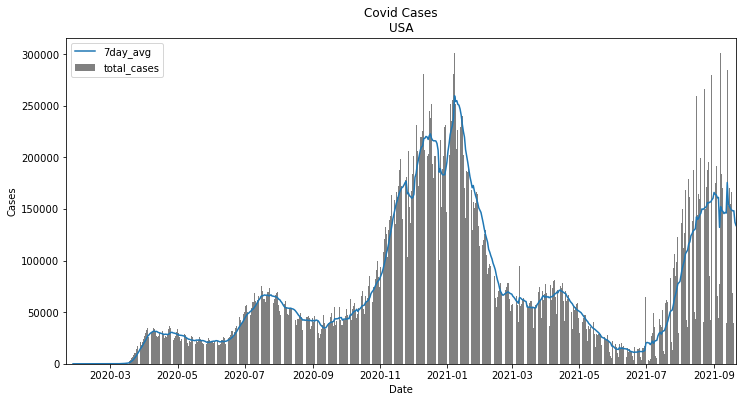

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(us_covid.date,
       us_covid.cases,
       color='gray',
      label="total_cases")
ax.plot(us_covid.date,us_covid.day_avg_cases, label='7day_avg')
ax.set(xlabel="Date",
       ylabel="Cases",
       title="Covid Cases\nUSA",
       xlim=[min(us_covid.date), max((us_covid.date))])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

## US - States metrics

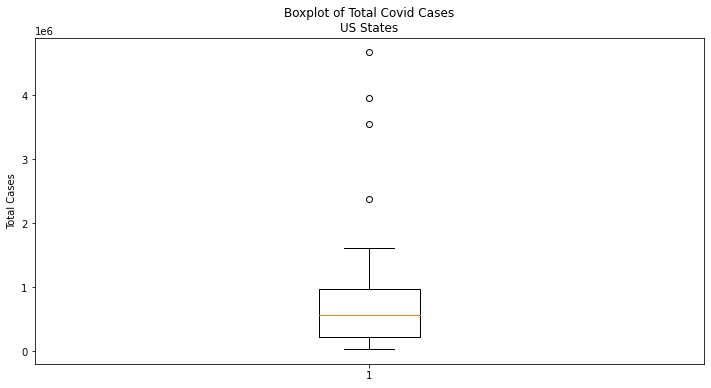

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(covid_df.groupby('state').sum()['cases'])
ax.set(ylabel="Total Cases",
       title="Boxplot of Total Covid Cases\nUS States")
plt.show()

### Calculate relative cases and deaths

In [17]:
states_population = pd.read_csv('../data/external/states_population.csv')

In [18]:
states_population.head()

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929
1,2,Texas,29730311,0.0385,28628666,25241971,0.1778,0.0889,113.8081
2,3,Florida,21944577,0.0330,21244317,18845537,0.1644,0.0656,409.2229
3,4,New York,19299981,-0.0118,19530351,19399878,-0.0051,0.0577,409.5400
4,5,Pennsylvania,12804123,0.0003,12800922,12711160,0.0073,0.0383,286.1704


In [19]:
total_by_state = covid_df[['state','deaths','cases']][covid_df.date > '2021-07-01'].groupby('state').sum()
total_by_state = total_by_state.join(states_population.set_index('State'))
total_by_state['relative_cases'] = total_by_state.cases / total_by_state.Pop
total_by_state['relative_deaths'] = total_by_state.deaths / total_by_state.Pop

In [20]:
total_by_state.head()

,deaths,cases,rank,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density,relative_cases,relative_deaths
state,,,,,,,,,,,,
Alabama,2108,224548,24,4934193,0.0095,4887681,4785437,0.0311,0.0147,97.4271,0.045509,0.000427
Alaska,103,31882,49,724357,-0.0147,735139,713910,0.0146,0.0022,1.2694,0.044014,0.000142
Arizona,1647,175410,14,7520103,0.0506,7158024,6407172,0.1737,0.0225,66.2016,0.023325,0.000219
Arkansas,1590,136768,34,3033946,0.0080,3009733,2921964,0.0383,0.0091,58.3059,0.045079,0.000524
California,4958,803289,1,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929,0.020278,0.000125


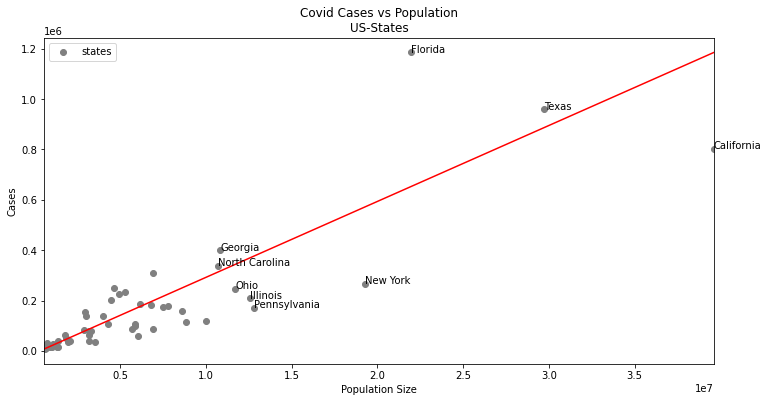

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(total_by_state.Pop,
       total_by_state.cases,
       color='gray',
      label="states")

ax.set(xlabel="Population Size",
       ylabel="Cases",
       title="Covid Cases vs Population\nUS-States",
       xlim=[min(total_by_state.Pop), max((total_by_state.Pop))])
ax.legend(loc='best')

for i, txt in enumerate(total_by_state.index):
    if total_by_state.Pop.iloc[i] > 10000000:
        ax.annotate(txt, (total_by_state.Pop.iloc[i], total_by_state.cases.iloc[i]))

line_limits_y = (total_by_state.cases.min(), total_by_state.cases.max()) 
line_limits_x = (total_by_state.Pop.min(), total_by_state.Pop.max())   
plt.plot(line_limits_x, line_limits_y, 'k-', color = 'r')

plt.show()

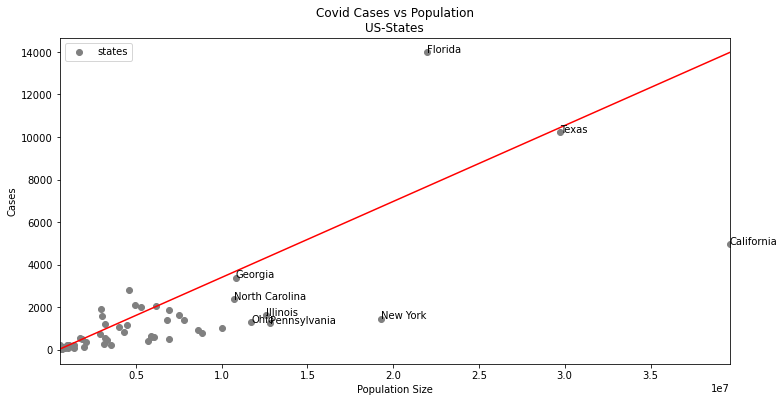

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(total_by_state.Pop,
       total_by_state.deaths,
       color='gray',
      label="states")

ax.set(xlabel="Population Size",
       ylabel="Cases",
       title="Covid Cases vs Population\nUS-States",
       xlim=[min(total_by_state.Pop), max((total_by_state.Pop))])
ax.legend(loc='best')

for i, txt in enumerate(total_by_state.index):
    if total_by_state.Pop.iloc[i] > 10000000:
        ax.annotate(txt, (total_by_state.Pop.iloc[i], total_by_state.deaths.iloc[i]))

line_limits_y = (total_by_state.deaths.min(), total_by_state.deaths.max()) 
line_limits_x = (total_by_state.Pop.min(), total_by_state.Pop.max())   
plt.plot(line_limits_x, line_limits_y, 'k-', color = 'r')

plt.show()

In [23]:
print(f'US total cases: {total_by_state.cases.sum():,}')
print(f'US Estimated population: {total_by_state.Pop.sum():,}')
print(f'Cases by population: {total_by_state.cases.sum() / total_by_state.Pop.sum():.4}')
print(f'Variance: {total_by_state.relative_cases.var():.4}')
print(f'Std deviation: {total_by_state.relative_cases.std():.4}')

US total cases: 8,691,543
US Estimated population: 334,537,941
Cases by population: 0.02598
Variance: 0.0001591
Std deviation: 0.01261


In [24]:
def states_metrics(state:str, alternative: str):
    print(f'{state} total cases: {total_by_state.cases[state]:,}')
    print(f'{state} cases from US total: {total_by_state.cases[state] / total_by_state.cases.sum():.4}')
    print(f'{state} estimated population: {total_by_state.Pop[state]:,}')
    print(f'{state} cases by population: {total_by_state.cases[state] / total_by_state.Pop[state]:.4}')

### Florida

In [25]:
states_metrics('Florida', 'larger')

Florida total cases: 1,185,261
Florida cases from US total: 0.1364
Florida estimated population: 21,944,577
Florida cases by population: 0.05401


### New York

In [26]:
states_metrics('New York', 'smaller')

New York total cases: 266,620
New York cases from US total: 0.03068
New York estimated population: 19,299,981
New York cases by population: 0.01381


In [27]:
total_by_state[['deaths', 'cases', 'relative_cases','relative_deaths', 'density']].corr()

,deaths,cases,relative_cases,relative_deaths,density
deaths,1.000000,0.963168,0.443138,0.535591,-0.079024
cases,0.963168,1.000000,0.396025,0.433083,-0.092579
relative_cases,0.443138,0.396025,1.000000,0.871808,-0.184736
relative_deaths,0.535591,0.433083,0.871808,1.000000,-0.192620
density,-0.079024,-0.092579,-0.184736,-0.192620,1.000000


## Mask Use

>This data comes from a large number of interviews conducted online by the global data and survey firm Dynata at the request of The New York Times. The firm asked a question about mask use to obtain 250,000 survey responses between July 2 and July 14, enough data to provide estimates more detailed than the state level. (Several states have imposed new mask requirements since the completion of these interviews.)
>
>Specifically, each participant was asked: How often do you wear a mask in public when you expect to be within six feet of another person?
>
>This survey was conducted a single time, and at this point we have no plans to update the data or conduct the survey again."

https://github.com/nytimes/covid-19-data/tree/master/mask-use

In [28]:
mask_use_df = pd.read_csv('../data/external/mask_use.csv', dtype={'COUNTYFP':str})
mask_use_df['STATEFP'] = mask_use_df.COUNTYFP.str[:2]
mask_use_df = mask_use_df.join(covid_df[['state','fips']].drop_duplicates().set_index('fips'), how='left', on='STATEFP')
mask_use_df.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,STATEFP,state
0,01001,0.053,0.074,0.134,0.295,0.444,01,Alabama
1,01003,0.083,0.059,0.098,0.323,0.436,01,Alabama
2,01005,0.067,0.121,0.120,0.201,0.491,01,Alabama
3,01007,0.020,0.034,0.096,0.278,0.572,01,Alabama
4,01009,0.053,0.114,0.180,0.194,0.459,01,Alabama


In [29]:
mask_use_df_melt = mask_use_df.melt(id_vars=["state", "STATEFP",'COUNTYFP'], var_name="frequency", value_name="value")
mask_use_df_melt.head()

,state,STATEFP,COUNTYFP,frequency,value
0,Alabama,01,01001,NEVER,0.053
1,Alabama,01,01003,NEVER,0.083
2,Alabama,01,01005,NEVER,0.067
3,Alabama,01,01007,NEVER,0.020
4,Alabama,01,01009,NEVER,0.053


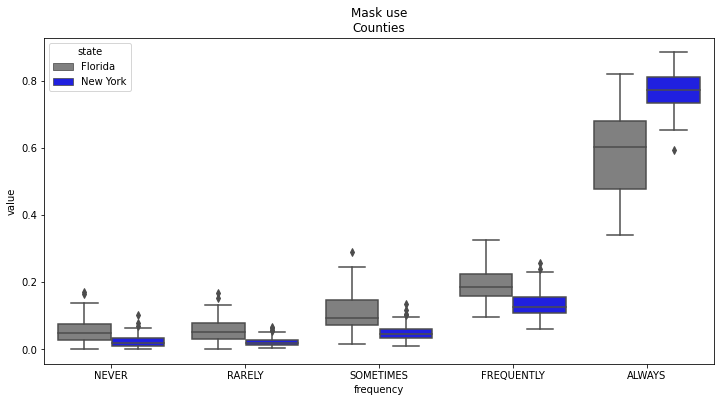

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Mask use\nCounties")
ax = sns.boxplot(x="frequency", y="value", hue="state",
                 data=mask_use_df_melt[mask_use_df_melt.state.isin({'Florida', 'New York'})], 
                 dodge=True, ax = ax, palette=['gray','blue'])

In [31]:
mask_use_df.head().mean()[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]

<ipython-input-31-0b4f41c63204>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask_use_df.head().mean()[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]


NEVER         0.0552
RARELY        0.0804
SOMETIMES     0.1256
FREQUENTLY    0.2582
ALWAYS        0.4804
dtype: float64

,sumsquare_error,aic,bic,kl_div
lognorm,8.802051,35.394132,-18443.355752,inf
norm,11.038187,26.977538,-17740.134827,inf


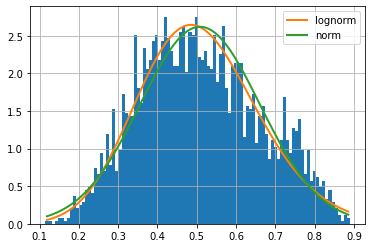

In [32]:
f = Fitter(mask_use_df.ALWAYS,
           distributions=['lognorm',
                          "norm"])
f.fit()
f.summary()

((array([-3.51414897, -3.271219  , -3.13692245, ...,  3.13692245,
          3.271219  ,  3.51414897]),
  array([0.115, 0.129, 0.139, ..., 0.88 , 0.884, 0.889])),
 (0.15142981112884693, 0.508093570973902, 0.994153957101986))

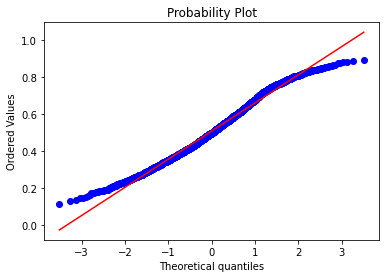

In [33]:
stats.probplot(mask_use_df.ALWAYS, plot=plt)

In [34]:
k2, p_val = stats.normaltest(mask_use_df.ALWAYS)
print(p_val)

2.0803311246336204e-31


### Correlation between mask use and cases by state

In [35]:
mask_use_df_states = mask_use_df.groupby('state').mean()
mask_use_df_states = mask_use_df_states.join(total_by_state[['deaths','cases','relative_cases','relative_deaths','density']])
mask_use_df_states.head()

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,deaths,cases,relative_cases,relative_deaths,density
state,,,,,,,,,,
Alabama,0.081567,0.081090,0.146612,0.215343,0.475313,2108,224548,0.045509,0.000427,97.4271
Alaska,0.055138,0.063172,0.089862,0.333103,0.458586,103,31882,0.044014,0.000142,1.2694
Arizona,0.049667,0.053200,0.094667,0.147333,0.655000,1647,175410,0.023325,0.000219,66.2016
Arkansas,0.090920,0.087253,0.138360,0.220627,0.462867,1590,136768,0.045079,0.000524,58.3059
California,0.032310,0.030724,0.063690,0.158603,0.714638,4958,803289,0.020278,0.000125,254.2929


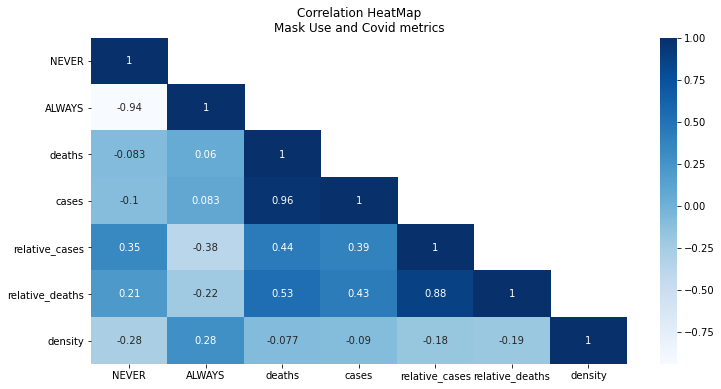

In [36]:
corr = mask_use_df_states.drop(['RARELY','SOMETIMES','FREQUENTLY'], axis=1).corr()
corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))


fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Correlation HeatMap\nMask Use and Covid metrics")
hmap=sns.heatmap(corr, ax=ax, cmap="Blues", annot=True)

## Hypothesis Test

Two Sample test for Means

In [37]:
significance_level = 0.05 

In [42]:
def check_requirements(sample1: np.array, sample2: np.array, population_array: np.array) -> bool:
    if len(sample1) > 30 and len(sample2) > 30:
        return True
    k2, p_val = stats.normaltest(population)
    print(f'Population normality test for column {col}, p-value: {p_val}')
    if p_val < significance_level:
        return True
    return False
    
def two_samples_test(state1: str, state2: str, col: str, alternative: str):
    sample1 = mask_use_df[mask_use_df.state == state1][col]
    sample2 = mask_use_df[mask_use_df.state == state2][col]
    
    print(f'{state1} number of counties: {len(sample1):,}')
    print(f'{state1} mask use = {col} mean: {sample1.mean():,}')
    print(f'{state2} number of counties: {len(sample2):,}')
    print(f'{state2} mask use = {col} mean: {sample2.mean():,}') 

    if check_requirements(sample1, sample2, mask_use_df[col]):
        t_stat, p_val = stats.ttest_ind(sample1, sample2, alternative=alternative)
         
        not_reject_msg = f"The data do not provide enough statistical evidence to say that, the mean of people saying they wear a mas {col} by county in {state1} is {alternative if alternative != 'two-sided' else 'different'} than in {state2}, with significance level of {significance_level:%}."
        reject_msg = f"The data provide enough statistical evidence to say that, the mean use of mask by county in {state1} is {alternative if alternative != 'two-sided' else 'different'} than in {state2}, with significance level of {significance_level:.0%}."
        print(f'T-stat: {t_stat}')
        print(f'P-value: {p_val}')
        if p_val < significance_level:
            print(reject_msg)
        else:
            print(not_reject_msg)

In [43]:
two_samples_test('Florida', 'New York', 'ALWAYS', 'less')

Florida number of counties: 67
Florida mask use = ALWAYS mean: 0.5825522388059703
New York number of counties: 62
New York mask use = ALWAYS mean: 0.7699354838709678
T-stat: -11.015198396868174
P-value: 1.610259295256832e-20
The data provide enough statistical evidence to say that, the mean use of mask by county in Florida is less than in New York, with significance level of 5%.


In [44]:
two_samples_test('New York', 'Florida', 'NEVER', 'less')

New York number of counties: 62
New York mask use = NEVER mean: 0.022838709677419345
Florida number of counties: 67
Florida mask use = NEVER mean: 0.05525373134328358
T-stat: -6.2199383862226485
P-value: 3.312792987060784e-09
The data provide enough statistical evidence to say that, the mean use of mask by county in New York is less than in Florida, with significance level of 5%.
